# Introduction
## Plotly plots
- Simple horizontal bar plot : Used to inspect the Target variable distribution
- Correlation Heatmap plot : Inspect the correlation between the different features
- Scatter plot : Compare the feature importances generated by Random Forest and Gradient-Boosted model
- Vertical bar plot : List in Descending order, the importance of the various features
- 3D Scatter plot  
  
1. **Data Quality Checks** : Visualising and evaluating all missing/Null values (values that are -1)
2. **Feature inspection and filtering** : Correlation and feature Mutual information plots against the target variable. Inspect of the Binary, categorical and other variables.
3. **Feature importance ranking via learning models** : Building a Random Forest and Gradient Boosted model to help us rank features based off the learning process.

In [1]:
# Let us load in the relevant Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

/Users/hansohyeon/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv('train.csv')
train.head()

id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   
1   9       0          1              1          7              0   
2  13       0          5              4          9              1   
3  16       0          0              1          2              0   
4  17       0          0              2          0              1   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ...  \
0              0              0              1              0  ...   
1              0              0              0              1  ...   
2              0              0              0              1  ...   
3              0              1              0              0  ...   
4              0              1              0              0  ...   

   ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0           9           1           5           8               0   
1           3           1           1           9               0   
2           4           2           7           7               0   
3           2           2           4           9               0   
4           3           1           1           3               0   

   ps_calc_16_bin  ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  \
0               1               1               0               0   
1               1               1               0               1   
2               1               1               0               1   
3               0               0               0               0   
4               0               0               1               1   

   ps_calc_20_bin  
0               1  
1               0  
2               0  
3               0  
4               0  

[5 rows x 59 columns]

In [3]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


# 1. Data Quality checks
## Null or missing values check
품질 검사의 일환으로 다음과 같이 train 데이터 세트에 null 값이 있는지 살펴보자.

In [4]:
# any() applied twice to check run the isnull check across all columns.
train.isnull().any().any()

False

- Null 값 검사는 False를 반환하지만 이는 데이터가 "-1 값은 해당 기능이 관찰에서 누락되었음을 나타냄"으로 설명되므로 실제로 데이터 결측치 검사가 종료되었음을 의미하지는 않는다. 따라서 Porto Seguro가 데이터의 모든 null 값을 -1 값으로 전면적으로 대체한 것으로 간주한다.

In [5]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

<AxesSubplot:>

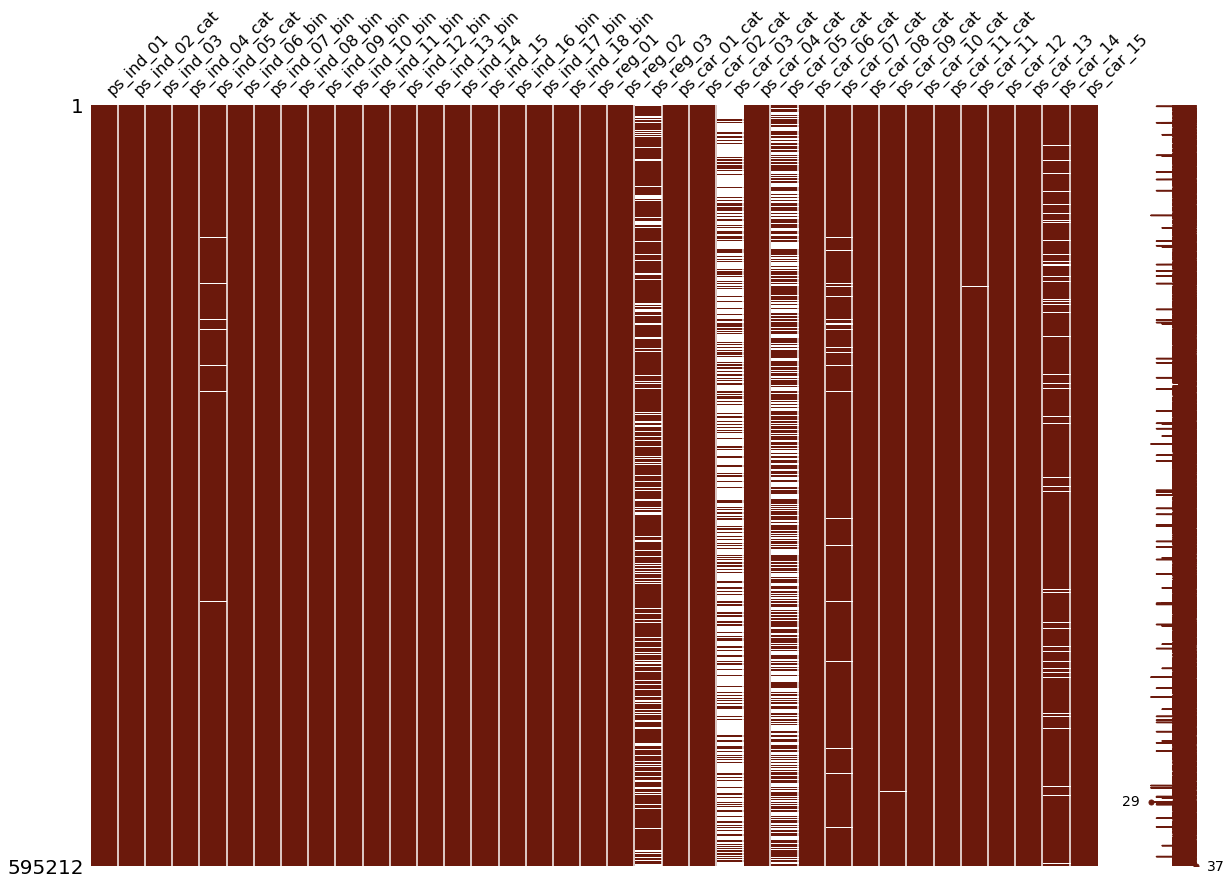

In [6]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:,2:39],figsize=(20,14),color=(0.42,0.1,0.05))

보다시피, 누락된 값은 이제 시각화할 때 훨씬 더 명확해지고, 수직의 진한 빨간색 밴드(누락되지 않은 데이터)에 겹쳐진 빈 흰색 밴드(누락된 데이터)는 데이터의 무효성을 반영한다. 그 특정 열에서. 이 예에서는 총 59개 기능 중 7개 기능이 실제로 null 값을 포함하고 있음을 확인할 수 있다(비록 Justin Nafe가 주석 섹션에서 올바르게 지적한 것처럼 실제로는 누락된 값이 있는 총 13개 열이 있음). 이는 누락된 매트릭스 플롯이 하나의 플롯에 약 40개의 이상한 feature만 편안하게 맞출 수 있고 그 후에는 일부 열이 제외될 수 있으므로 나머지 5개의 null 열이 제외되었기 때문이다.  

결측값이 발견된 columns :   
**ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14**   

대부분의 누락된 값은 접미사가 "_cat"인 열에서 발생한다. ps_reg_03, ps_car_03_cat 및 ps_car_05_cat 열에 대해 더 자세히 살펴보아야 한다. 흰색 밴드와 어두운 밴드의 비율을 보면 이 3개 열에서 대부분의 값이 누락되었음을 알 수 있으므로 null을 -1로 전면적으로 대체하는 것은 좋은 전략이 아닐 수 있다.  

## Target variable inspection
일반적으로 데이터에 대해 수행되는 또 다른 표준 검사는 target 변수에 관한 것이다. 이 경우 열의 title은 편리하게 "target"이다. target value는 또한 class/label/correct이라는 이름으로 제공되며 지도 학습 모델에서 제공된 해당 데이터(이 경우에는 id 열을 제외한 모든 학습 데이터)와 함께 사용되어 가장 잘 매핑되는 함수를 학습한다. 이 학습된 함수가 보이지 않는 새로운 데이터로 잘 일반화하고 예측할 수 있기를 바라면서 데이터를 target으로 한다.

In [7]:
data = [go.Bar(x = train["target"].value_counts().index.values, 
              y = train["target"].value_counts().values,
              text = "Distribution of target variable")]
layout = go.Layout(title = "Target variable distribution")
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

## Dayatype check
이 검사는 제공된 데이터에 대한 더 나은 개요를 얻기 위해 train 세트가 정수, 문자 또는 부동 소수점 등 어떤 종류의 데이터 유형으로 구성되어 있는지 확인하기 위해 수행된다. Python 시퀀스에서 고유한 유형의 개수를 얻는 한 가지 방법은 다음과 같이 컬렉션 모듈을 가져올 때 Counter 메서드를 사용하는 것이다.

In [8]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

 train 데이터 세트를 구성하는 총 59개의 열이 있으며 이 검사에서 볼 수 있듯이 feature/열은 정수와 부동 소수점이라는 두 가지 데이터 유형으로만 구성된다.  

또 다른 주목해야 할 점은 Porto Seguro가 실제로 "_bin", "_cat" 및 "_reg"와 같은 약어가 접미사로 붙은 헤더와 함께 데이터를 제공했다는 것이다. 여기서 그들은 _bin은 binary feature를 나타내고 _cat은 categorical feature를 나머지는 연속형 또는 순서형 특성을 나타낸다는 대략적인 설명을 제공했다. 여기서는 부동 소수점 값(연속 특성만)과 정수 데이터 유형(이진, 범주 및 순서 특성)을 살펴봄으로써 이를 좀 더 단순화한다.

In [9]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

### Correlation plots
**Correlation of float features**

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

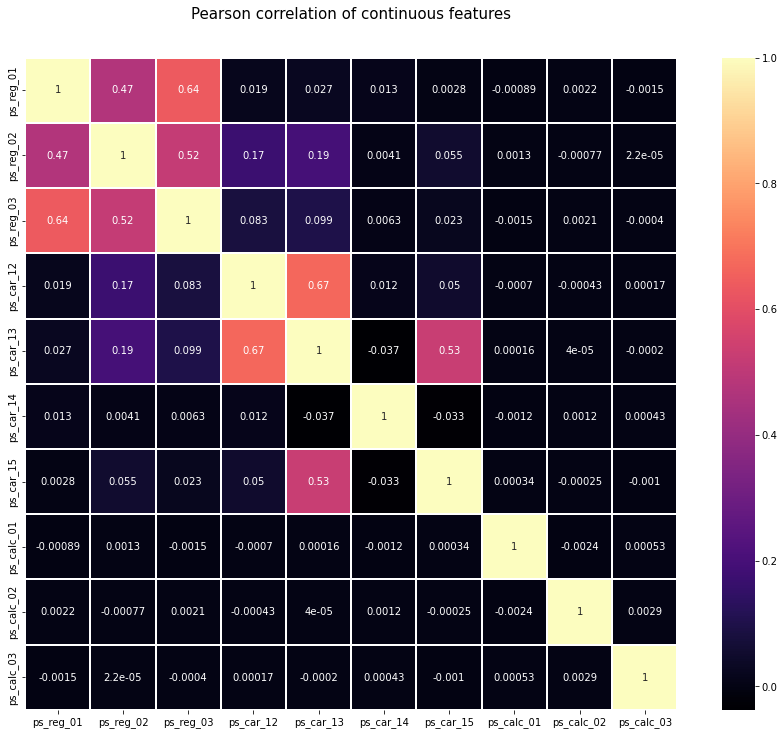

In [10]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white',annot=True)

가장 긍정적인 상관관계를 가진 features:  
(ps_reg_01, ps_reg_03), (ps_reg_02, ps_reg_03), (ps_car_12, ps_car_13), (ps_car_13, ps_car_15)  

**Correlation of integer feature**

In [11]:
# train_int = train_int.drop(["id","target"],axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21,16))
# plt.title('Pearson correlation of categorical features', y=1.05, size=15)
# sns.heatmap(train_cat.corr(), linewidth=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white',annot=False)

data = [
    go.Heatmap(
        z= train_int.corr().values,
        x=train_int.columns.values.astype(str),
        y=train_int.columns.values.astype(str),
        colorscale='Viridis',
        reversescale = False,
        #text = True ,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

마찬가지로, 서로 선형적으로 전혀 상관되지 않은 엄청난 수의 열이 있다는 것을 관찰할 수 있다. 이는 상관 관계 플롯에서 상당히 많은 0 값 셀을 관찰한다는 사실이 분명하다. PCA(주성분 분석)와 같은 차원 축소 변환을 수행하려는 경우에는 어느 정도의 상관관계가 필요하다. 관심 있는 몇 가지 feature은 다음과 같습니다.  

**Negatively correlated fature**: ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin  

주목해야 할 흥미로운 측면 중 하나는 nullity에 대한 이전 분석에서 ps_car_03_cat 및 ps_car_05_cat에 많은 누락 또는 null 값이 포함된 것으로 밝혀졌다는 것이다. 따라서 이 두 feature가 데이터의 기본 진실을 실제로 반영하지 않을 수도 있지만 이를 기반으로 서로 매우 강한 양의 선형 상관 관계를 나타내는 것은 놀라운 일이 아니다.

### Mutual Information plots
Mutual information은 target 변수와 계산 대상인 해당 feature 간의 상호 정보를 검사할 수 있는 또 다른 유용한 도구이다. 분류 문제의 경우 두 개의 무작위 변수 사이의 종속성을 측정하고 0(임의의 변수가 서로 독립적인 경우)부터 더 높은 값(일부 종속성을 나타냄)까지 범위를 측정하는 Sklearn의mutual_info_classif 메서드를 편리하게 호출할 수 있다. 따라서 이는 target의 정보가 기능 내에 얼마나 포함될 수 있는지에 대한 아이디어를 제공하는 데 도움이 된다.

In [12]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


### Binary features inspection
검사할 데이터의 또 다른 측면은 이진 값만 포함하는 열이다. 즉, 값이 두 값 1 또는 0 중 하나만 사용하는 경우이다. 이러한 이진 값을 포함하는 모든 열을 저장한 다음 생성한다.

In [13]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col :
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [14]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list,
    name = 'Zero count')

trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count')

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title = 'Count of 1 and 0 in binary variables')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

여기서  ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin의 4가지 기능이 완전히 0으로 지배된다는 것을 알 수 있다. 이는 이러한 feature가 target과 비교하여 다른 클래스에 대한 많은 정보를 포함하지 않기 때문에 전혀 유용한지 여부에 대한 의문을 제기한다.

## Categorical and Ordinal feature inspection
접미사 "_cat"에 따라 범주형이라고 불리는 feature를 살펴보자  

## Feature importance via Random Forest
Random Forest Classifier를 사용하여 train 데이터를 맞추고 모델이 훈련을 마친 후 feature의 순위를 살펴보는 Random Forest 모델을 구현해 보자. 이는 유용한 feature 중요도를 얻는 데 많은 매개변수 조정이 필요하지 않고 target 불균형에도 매우 강력한 앙상블 모델(부트스트랩 집계에 적용된 약한 결정 트리 학습기의 앙상블)을 사용하는 빠른 방법이다.

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf = 4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id','target'], axis=1), train.target)
features = train.drop(['id','target'],axis=1).columns.values
print("---- Training Done ----")

---- Training Done ----


### Plot.ly Scatter Plot of feature importances
Random Forest를 훈련한 후 "featureimportances" 속성을 호출하여 기능 중요도 목록을 얻고 다음 Plotly 플롯인 Scatter 플롯을 그릴 수 있다.  

여기서는 Scatter 명령을 호출하고 이전 Plotly 플롯에 따라 y축과 x축을 정의해야 한다. 그러나 분산형 차트에서 주목해야 할 한 가지는 마커 속성이다. 포함된 분산점의 크기, 색상 및 배율을 정의하고 제어하는 것은 마커 속성이다.

In [16]:
# Scatter plot
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13, 
        #size = rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale = 'Portland',
        showscale = True),
    text = features)

data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
    xaxis = dict(
        ticklen = 5,
        showgrid = False,
        zeroline = False,
        showline = False),
    yaxis = dict(
        title = 'Feature Importance',
        showgrid = False,
        zeroline = False,
        ticklen = 5,
        gridwidth = 2),
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

또한 다음과 같이 동일한 플롯 막대 그래프를 통해 중요도 순서에 따라 순위가 매겨진 모든 feature의 정렬된 목록을 표시할 수도 있다.

In [17]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), reverse = False)))

trace2 = go.Bar(
    x=x,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True),
    name = 'Random Forest Feature importance',
    orientation = 'h',)

layout = dict(
    title = 'Barplot of Feature importances',
    width = 900, height = 2000,
    yaxis = dict(
        showgrid = False,
        showline = False,
        showticklabels = True,
        # domain = [0, 0.85]
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

### Decision Tree visualisation

자주 사용되는 또 다른 흥미로운 트릭이나 기술은 모델이 내린 나뭇가지나 결정을 시각화하는 것이다. 단순화를 위해 의사결정 트리(max_깊이 = 3)를 맞추므로 의사결정 분기에서 3개 수준만 볼 수 있다. sklearn "export_graphviz"의 그래프 시각화 속성으로 내보내기를 사용한 다음 시각화를 위해 트리 이미지를 내보내고 가져온다.

In [18]:
!pip install graphviz

In [19]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(train.drop(['id', 'target'],axis=1), train.target)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = train.drop(['id', 'target'],axis=1).columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

FileNotFoundError: [Errno 2] No such file or directory: 'dot'

### Feature importance via Gradient Boosting model

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [35]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [36]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

Interestingly we observe that in both Random forest and Gradient Boosted learning models, the most important feature that both models picked out was the column : **ps_car_13**.